In [1]:
#Importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import log_loss
sns.set_style("darkgrid")
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, Bidirectional, Dropout, concatenate
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_curve, auc, mean_squared_error,  mean_absolute_error, jaccard_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from scipy.stats import zscore
from scipy import stats

In [2]:
#Loading the dataset
dataset = pd.read_csv('GHL.csv')
dataset = dataset.dropna()

In [3]:
# extract the features and target variable
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values


In [4]:
# preprocess the dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)
le = LabelEncoder()
y = le.fit_transform(y)


In [5]:
from imblearn.over_sampling import SMOTE
#smote = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=42)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [6]:
# split the dataset into training, testing, and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [7]:
# apply information gain for feature selection
 # Number of features to select
X_train = pd.DataFrame(X_train, columns=['RT_level_ini','DANGER','FAULT','RT_temperature.T','HT_temperature.T',
                                         'RT_level','out_valve_act','dT_rand','inv_valve_act','limiter.y',
                                         'inj_valve_act','Relaxing.active','boundary.m_flow_in','dir_valve_act',
                                         'dt_rand','C_level','C_temperature.T','heater_act',
                                         'HT_level','limiter1.y','dL_rand'
])

In [8]:
mutual_info= mutual_info_classif(X_train, y_train)
mutual_info

array([0.6074341 , 0.29515311, 0.01078369, 0.68830187, 0.29148276,
       0.64156829, 0.01535461, 0.61147436, 0.02444875, 0.42691245,
       0.04949069, 0.07077479, 0.05276671, 0.02213753, 0.6678154 ,
       0.61268473, 0.6092502 , 0.16820846, 0.16598971, 0.6677875 ,
       0.61191272])

In [9]:

mutual_info= pd.Series(mutual_info)
mutual_info.index= X_train.columns
mutual_info.sort_values(ascending=False)

RT_temperature.T      0.688302
dt_rand               0.667815
limiter1.y            0.667788
RT_level              0.641568
C_level               0.612685
dL_rand               0.611913
dT_rand               0.611474
C_temperature.T       0.609250
RT_level_ini          0.607434
limiter.y             0.426912
DANGER                0.295153
HT_temperature.T      0.291483
heater_act            0.168208
HT_level              0.165990
Relaxing.active       0.070775
boundary.m_flow_in    0.052767
inj_valve_act         0.049491
inv_valve_act         0.024449
dir_valve_act         0.022138
out_valve_act         0.015355
FAULT                 0.010784
dtype: float64

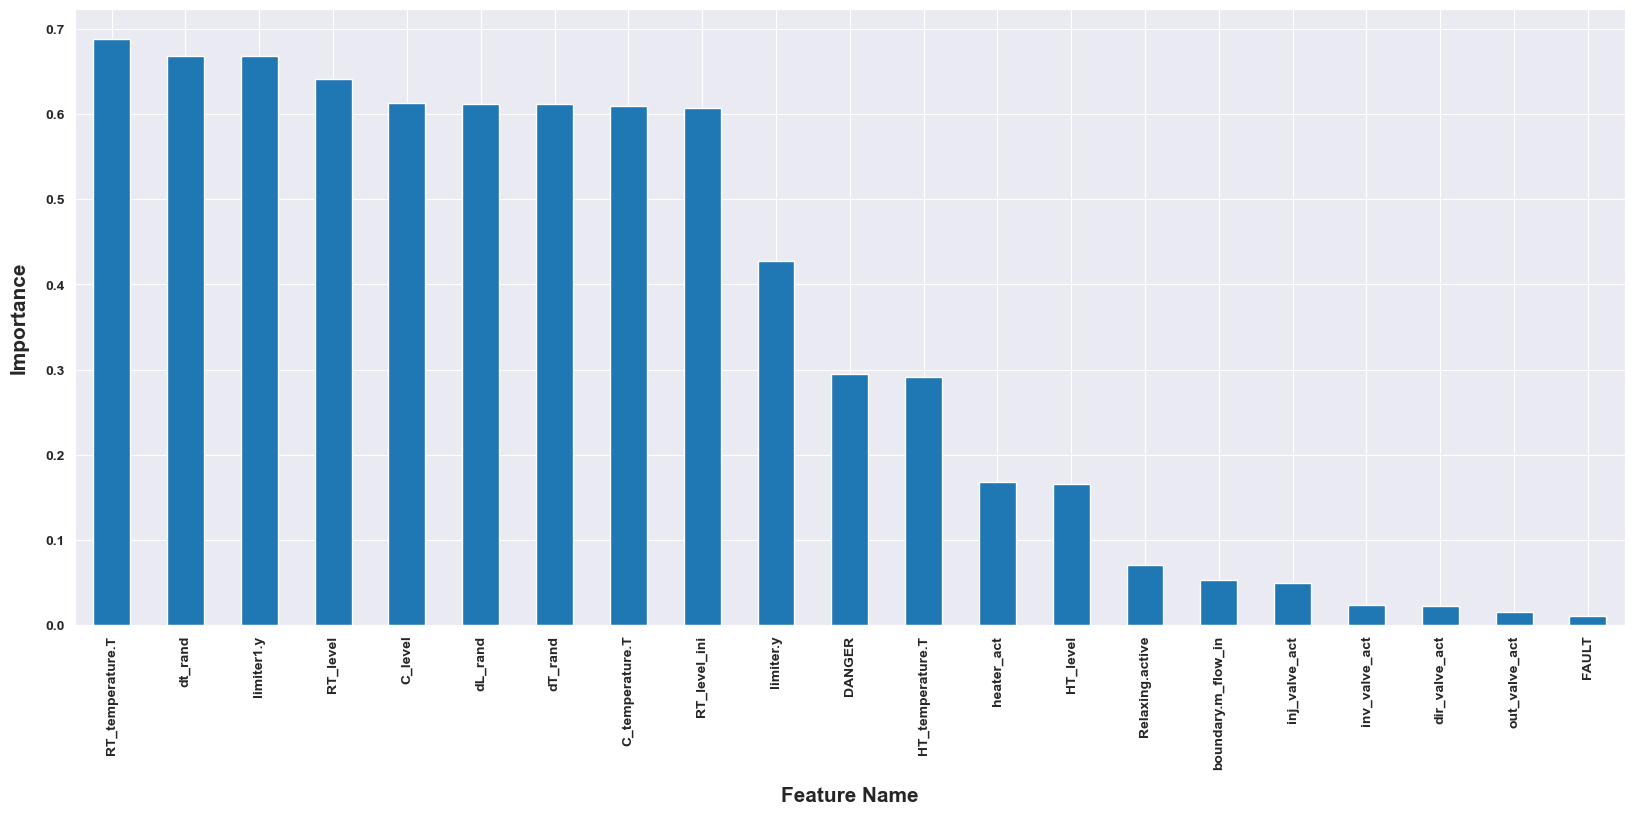

In [10]:
#Lets plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20,8))
plt.xticks(weight="bold", rotation=90)
plt.yticks(weight="bold")
plt.xlabel("Feature Name", weight="bold", labelpad=12,fontsize=15)
plt.ylabel("Importance",weight="bold", labelpad=12,fontsize=15)
#plt.legend()
plt.show()

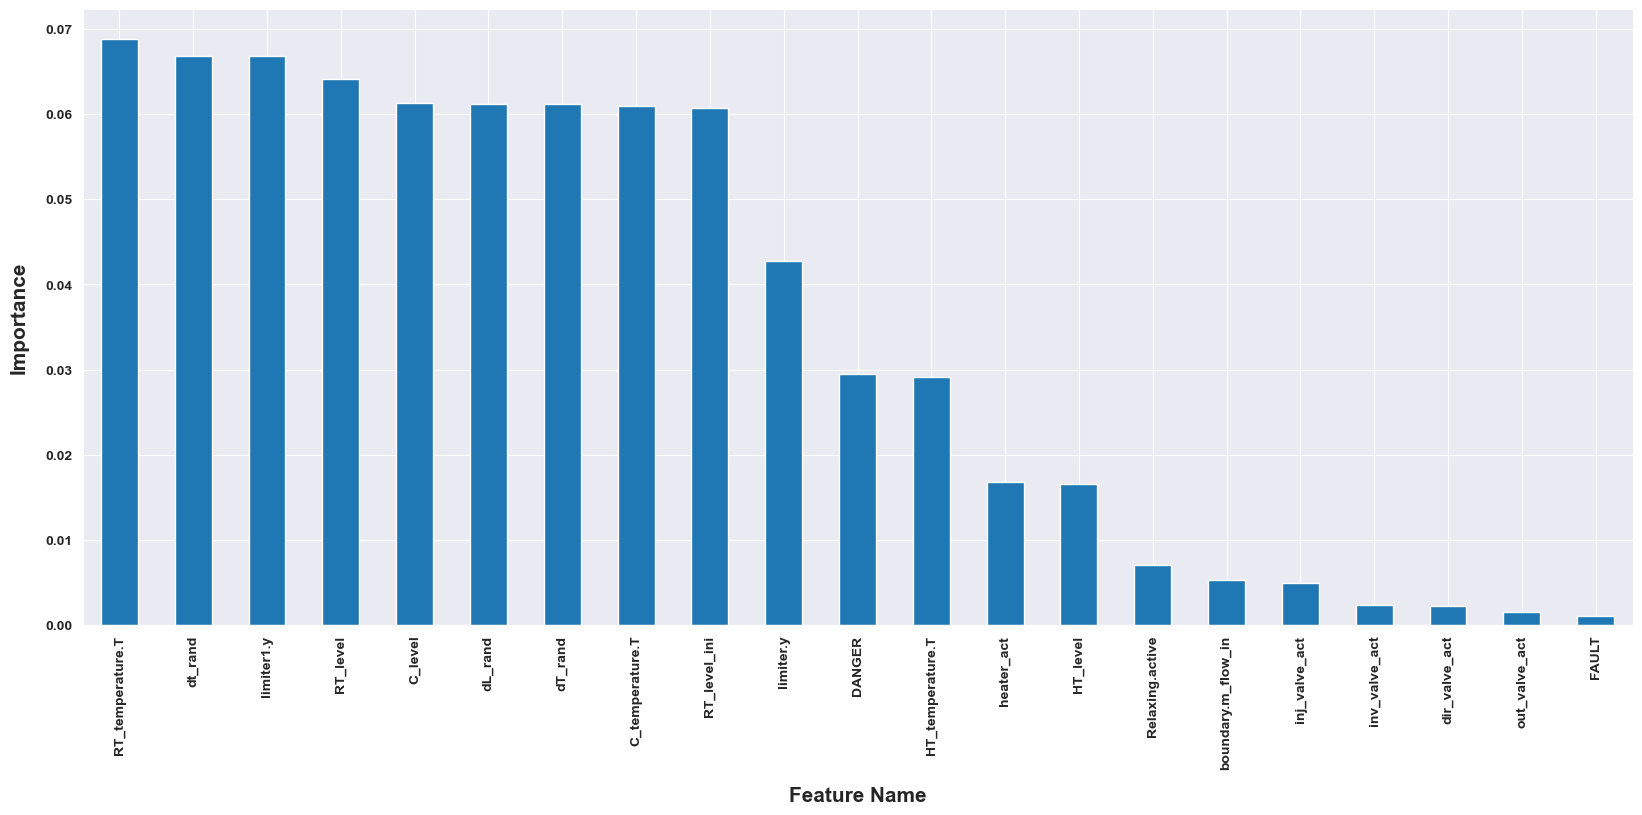

In [11]:

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Function to format the y-axis labels
def format_yticks(x, pos):
    return f'{x / 10:.2f}'

# Plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))
plt.xticks(weight="bold", rotation=90)
plt.yticks(weight="bold")
plt.xlabel("Feature Name", weight="bold", labelpad=12, fontsize=15)
plt.ylabel("Importance", weight="bold", labelpad=12, fontsize=15)

# Apply the custom formatter to the y-axis
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(format_yticks))

plt.show()


In [12]:
# apply information gain for feature selection
 # Number of features to select
selector = SelectKBest(mutual_info_classif, k=9)
X_train = selector.fit_transform(X_train.fillna(0), y_train)
X_test = selector.transform(X_test)
X_val = selector.transform(X_val)

C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


In [13]:
# apply SparsePCA for feature reduction
spca = SparsePCA(n_components=7)
X_train = spca.fit_transform(X_train)
X_val = spca.transform(X_val)
X_test = spca.transform(X_test)


In [14]:
# Reshape the data for the LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1],1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import Layer

# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        logits = tf.matmul(inputs, self.W)
        attention_weights = tf.nn.softmax(logits, axis=1)
        weighted_sum = tf.reduce_sum(inputs * attention_weights, axis=1)
        return weighted_sum

rnn_model = Sequential()
rnn_model.add(Dense(units=128, activation='relu', input_shape=(X_train.shape[1], 1)))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(units=64, activation='relu', return_sequences=True))
rnn_model.add(Dropout(0.2))
# Add attention mechanism after the second LSTM layer
rnn_model.add(AttentionLayer())

# Reshape the output of the Attention layer to add the missing timestep dimension
rnn_model.add(tf.keras.layers.Reshape((1, -1)))

rnn_model.add(SimpleRNN(units=32, activation='relu', return_sequences=False))
rnn_model.add(Dropout(0.2))

rnn_model.add(Dense(units=1, activation='sigmoid'))
rnn_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import Layer

# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        logits = tf.matmul(inputs, self.W)
        attention_weights = tf.nn.softmax(logits, axis=1)
        weighted_sum = tf.reduce_sum(inputs * attention_weights, axis=1)
        return weighted_sum

lstm_model = Sequential()
lstm_model.add(Dense(units=128, activation='relu', input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=64, activation='relu', return_sequences=True))
lstm_model.add(Dropout(0.2))
# Add attention mechanism after the second LSTM layer
lstm_model.add(AttentionLayer())

# Reshape the output of the Attention layer to add the missing timestep dimension
lstm_model.add(tf.keras.layers.Reshape((1, -1)))

lstm_model.add(LSTM(units=32, activation='relu', return_sequences=False))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(units=1, activation='sigmoid'))
lstm_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.layers import Layer

# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        logits = tf.matmul(inputs, self.W)
        attention_weights = tf.nn.softmax(logits, axis=1)
        weighted_sum = tf.reduce_sum(inputs * attention_weights, axis=1)
        return weighted_sum

# Assuming X_train.shape[1] represents the number of timesteps and 1 represents the number of features
bi_lstm_model = Sequential()
bi_lstm_model.add(Dense(units=128, activation='relu', input_shape=(X_train.shape[1], 1)))
bi_lstm_model.add(Dropout(0.2))
bi_lstm_model.add(Bidirectional(LSTM(units=64, activation='relu', return_sequences=True)))
bi_lstm_model.add(Dropout(0.2))
bi_lstm_model.add(AttentionLayer())  # Add attention mechanism after the Bi-LSTM layer

# Reshape the output of the Attention layer to add the missing timestep dimension
bi_lstm_model.add(tf.keras.layers.Reshape((1, -1)))

bi_lstm_model.add(Bidirectional(LSTM(units=32, activation='relu', return_sequences=False)))
bi_lstm_model.add(Dropout(0.2))

bi_lstm_model.add(Dense(units=1, activation='sigmoid'))
bi_lstm_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [18]:
#Define a learning rate schedular
def scheduler(epoch, lr):
    if epoch <=10:
        return lr #Keep the initial learning rate for the first 200 epochs
    else:
        return lr * tf.math.exp(-0.1) # Reduce the learning rate by a factor of 0.1 after the 200th epoch


In [19]:
lr=0.001
for i in range (100):
    lr=scheduler(i,lr)
    print(i,lr)

0 0.001
1 0.001
2 0.001
3 0.001
4 0.001
5 0.001
6 0.001
7 0.001
8 0.001
9 0.001
10 0.001
11 tf.Tensor(0.00090483745, shape=(), dtype=float32)
12 tf.Tensor(0.0008187308, shape=(), dtype=float32)
13 tf.Tensor(0.0007408183, shape=(), dtype=float32)
14 tf.Tensor(0.0006703201, shape=(), dtype=float32)
15 tf.Tensor(0.00060653075, shape=(), dtype=float32)
16 tf.Tensor(0.00054881175, shape=(), dtype=float32)
17 tf.Tensor(0.0004965854, shape=(), dtype=float32)
18 tf.Tensor(0.00044932903, shape=(), dtype=float32)
19 tf.Tensor(0.0004065697, shape=(), dtype=float32)
20 tf.Tensor(0.0003678795, shape=(), dtype=float32)
21 tf.Tensor(0.00033287113, shape=(), dtype=float32)
22 tf.Tensor(0.00030119426, shape=(), dtype=float32)
23 tf.Tensor(0.00027253185, shape=(), dtype=float32)
24 tf.Tensor(0.00024659702, shape=(), dtype=float32)
25 tf.Tensor(0.0002231302, shape=(), dtype=float32)
26 tf.Tensor(0.00020189656, shape=(), dtype=float32)
27 tf.Tensor(0.00018268357, shape=(), dtype=float32)
28 tf.Tensor(0.00

In [20]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',  # monitor validation loss
                               patience=3,         # number of epochs to wait before stopping
                            restore_best_weights=True)

In [21]:
callback=LearningRateScheduler(scheduler)

In [22]:
history = rnn_model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train, 
                    validation_data=(X_val.reshape((X_val.shape[0], X_val.shape[1], 1)), y_val),
                    epochs=100, batch_size=64, verbose=1, callbacks=[callback,early_stopping ])

Epoch 1/100


4018/4018 [==============================] - 25s 6ms/step - loss: 0.0074 - accuracy: 0.9903 - val_loss: 0.0018 - val_accuracy: 0.9981 - lr: 0.0010
Epoch 2/100
4018/4018 [==============================] - 22s 5ms/step - loss: 0.0024 - accuracy: 0.9976 - val_loss: 0.0018 - val_accuracy: 0.9982 - lr: 0.0010
Epoch 3/100
4018/4018 [==============================] - 22s 5ms/step - loss: 0.0023 - accuracy: 0.9976 - val_loss: 0.0018 - val_accuracy: 0.9982 - lr: 0.0010
Epoch 4/100
4018/4018 [==============================] - 22s 5ms/step - loss: 0.0021 - accuracy: 0.9978 - val_loss: 0.0018 - val_accuracy: 0.9982 - lr: 0.0010
Epoch 5/100
4018/4018 [==============================] - 21s 5ms/step - loss: 0.0022 - accuracy: 0.9978 - val_loss: 0.0018 - val_accuracy: 0.9982 - lr: 0.0010
Epoch 6/100
4018/4018 [==============================] - 22s 5ms/step - loss: 0.0021 - accuracy: 0.9979 - val_loss: 0.0018 - val_accuracy: 0.9982 - lr: 0.0010
Epoch 7/100
4018/4018 [=====================

In [23]:
history = lstm_model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train, 
                    validation_data=(X_val.reshape((X_val.shape[0], X_val.shape[1], 1)), y_val),
                    epochs=100, batch_size=64, verbose=1, callbacks=[callback,early_stopping ])

Epoch 1/100
4018/4018 [==============================] - 34s 8ms/step - loss: 0.0167 - accuracy: 0.9792 - val_loss: 0.0029 - val_accuracy: 0.9970 - lr: 0.0010
Epoch 2/100
4018/4018 [==============================] - 31s 8ms/step - loss: 0.0040 - accuracy: 0.9959 - val_loss: 0.0022 - val_accuracy: 0.9978 - lr: 0.0010
Epoch 3/100
4018/4018 [==============================] - 31s 8ms/step - loss: 0.0027 - accuracy: 0.9973 - val_loss: 0.0020 - val_accuracy: 0.9980 - lr: 0.0010
Epoch 4/100
4018/4018 [==============================] - 31s 8ms/step - loss: 0.0027 - accuracy: 0.9972 - val_loss: 0.0020 - val_accuracy: 0.9979 - lr: 0.0010
Epoch 5/100
4018/4018 [==============================] - 50s 12ms/step - loss: 0.0025 - accuracy: 0.9974 - val_loss: 0.0021 - val_accuracy: 0.9979 - lr: 0.0010
Epoch 6/100
4018/4018 [==============================] - 63s 16ms/step - loss: 0.0026 - accuracy: 0.9974 - val_loss: 0.0018 - val_accuracy: 0.9982 - lr: 0.0010
Epoch 7/100
4018/4018 [=====================

In [24]:
history = bi_lstm_model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train, 
                    validation_data=(X_val.reshape((X_val.shape[0], X_val.shape[1], 1)), y_val),
                    epochs=100, batch_size=64, verbose=1, callbacks=[callback,early_stopping ])

Epoch 1/100
4018/4018 [==============================] - 86s 20ms/step - loss: 0.0101 - accuracy: 0.9877 - val_loss: 0.0019 - val_accuracy: 0.9981 - lr: 0.0010
Epoch 2/100
4018/4018 [==============================] - 75s 19ms/step - loss: 0.0055 - accuracy: 0.9943 - val_loss: 0.0075 - val_accuracy: 0.9925 - lr: 0.0010
Epoch 3/100
4018/4018 [==============================] - 89s 22ms/step - loss: 0.0033 - accuracy: 0.9967 - val_loss: 0.0018 - val_accuracy: 0.9982 - lr: 0.0010
Epoch 4/100
4018/4018 [==============================] - 81s 20ms/step - loss: 0.0030 - accuracy: 0.9969 - val_loss: 0.0020 - val_accuracy: 0.9980 - lr: 0.0010
Epoch 5/100
4018/4018 [==============================] - 82s 21ms/step - loss: 0.0023 - accuracy: 0.9977 - val_loss: 0.0020 - val_accuracy: 0.9980 - lr: 0.0010
Epoch 6/100
4018/4018 [==============================] - 51s 13ms/step - loss: 0.0030 - accuracy: 0.9970 - val_loss: 0.0018 - val_accuracy: 0.9981 - lr: 0.0010


In [25]:
# Predict probabilities for three models
rnn_pred = rnn_model.predict(X_test)
lstm_pred = lstm_model.predict(X_test)
bi_lstm_pred = bi_lstm_model.predict(X_test)



2511/2511 [==============================] - 10s 4ms/step


In [26]:
# Compute ROC curve and area under curve (AUC) for all models
rnn_fpr, rnn_tpr, rnn_thresholds = roc_curve(y_test, rnn_pred)
lstm_fpr, lstm_tpr, lstm_thresholds = roc_curve(y_test, lstm_pred)
bi_lstm_fpr, bi_lstm_tpr, bi_lstm_thresholds = roc_curve(y_test, bi_lstm_pred)
rnn_auc = auc(rnn_fpr, rnn_tpr)
lstm_auc = auc(lstm_fpr, lstm_tpr)
bi_lstm_auc = auc(bi_lstm_fpr, bi_lstm_tpr)

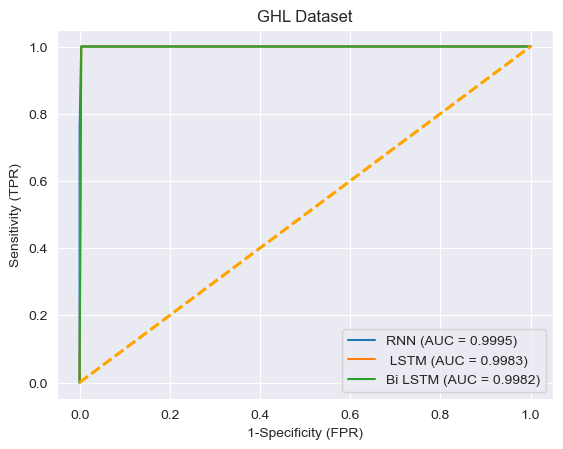

In [27]:
plt.plot(rnn_fpr, rnn_tpr, label='RNN (AUC = {:.4f})'.format(rnn_auc))
plt.plot(lstm_fpr, lstm_tpr, label=' LSTM (AUC = {:.4f})'.format(lstm_auc))
plt.plot(bi_lstm_fpr, bi_lstm_tpr, label='Bi LSTM (AUC = {:.4f})'.format(bi_lstm_auc))
plt.plot([0, 1], [0, 1],[0,1], color='orange', lw=2, linestyle='--')
plt.xlabel('1-Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.title('GHL Dataset')
plt.legend()
plt.show()

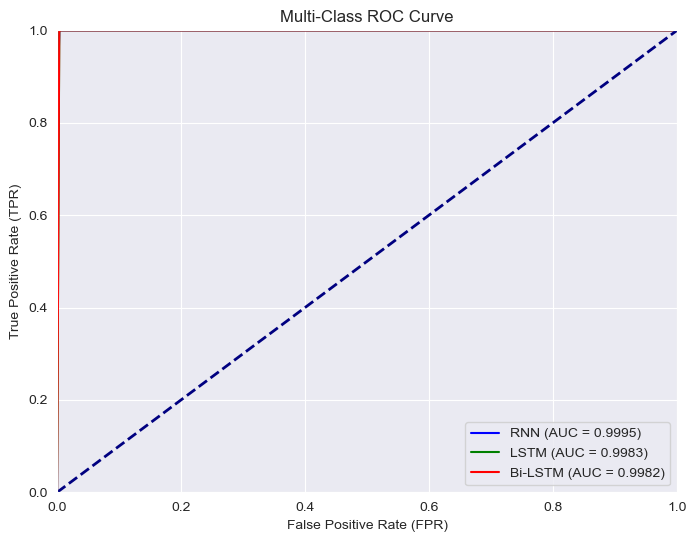

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have RNN, LSTM, and Bi-LSTM predictions (replace with your data)
rnn_fpr, rnn_tpr, _ = roc_curve(y_test, rnn_pred)  # Replace with actual values
lstm_fpr, lstm_tpr, _ = roc_curve(y_test, lstm_pred)  # Replace with actual values
bi_lstm_fpr, bi_lstm_tpr, _ = roc_curve(y_test, bi_lstm_pred)  # Replace with actual values
rnn_auc = auc(rnn_fpr, rnn_tpr)
lstm_auc = auc(lstm_fpr, lstm_tpr)
bi_lstm_auc = auc(bi_lstm_fpr, bi_lstm_tpr)

# Define colors based on the image (replace with desired colors if needed)
colors = ['blue', 'green', 'red']

# Plot ROC curves with specific colors
plt.figure(figsize=(8, 6))
plt.plot(rnn_fpr, rnn_tpr, color=colors[0], label=f'RNN (AUC = {rnn_auc:.4f})')
plt.plot(lstm_fpr, lstm_tpr, color=colors[1], label=f'LSTM (AUC = {lstm_auc:.4f})')
plt.plot(bi_lstm_fpr, bi_lstm_tpr, color=colors[2], label=f'Bi-LSTM (AUC = {bi_lstm_auc:.4f})')

# Reference line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Adjust plot according to the image
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)  # Add grid lines similar to the image

plt.show()
